### from spatialpca

#### cell level

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import squidpy as sq

In [4]:
#layer colormap
cm=mpl.colors.ListedColormap([ '#41425E','#E07D60', '#83AF98', '#F6CD95'])

<IPython.core.display.Javascript object>

In [5]:
scenarios = {"scenario_1":[0.85, 0.05, 0.05, 0.05],
            "scenario_2":[0.45, 0.45, 0.05, 0.05],
            "scenario_3":[0.60, 0.30, 0.05, 0.05],
            "scenario_4":[0.35, 0.30, 0.30, 0.05]}

In [6]:
def get_onehot_ct(init_assign = None):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(init_assign)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_ct = onehot_encoder.fit_transform(integer_encoded)
    return onehot_ct.astype(np.float32)

def move_list(lst, k):
    ## k>0 left move
    ## k<0 right move
    return lst[k:]+lst[:k]

In [7]:
def get_spaital_network(Num_sample = None, spatial = None,n_neighs = None,radius = None,coord_type = "grid",n_rings = 2,set_diag = False):
    spatial_adata = ad.AnnData(np.empty((Num_sample,1),dtype="float32"))
    spatial_adata.obsm["spatial"] = spatial
    sq.gr.spatial_neighbors(spatial_adata, n_rings=n_rings, coord_type=coord_type, n_neighs=n_neighs, radius=radius,set_diag =set_diag)
    sn = spatial_adata.obsp["spatial_connectivities"]
    
    return sn

In [8]:
def SpatialPCA_cell_level_sim(Num_sample = None, Num_celltype = 4,
                   image_width = None, image_height = None,
                  scenarios_mode = "scenario_1"):

    full_sample = image_width * image_height
    a, b = np.meshgrid(np.arange(image_width),
                       np.arange(image_height),
                       indexing='ij')
    ## Num_celltype is equal to Num_layer
    layer_label = np.repeat(np.arange(Num_celltype),full_sample/Num_celltype)  
    ct_label_init = np.zeros((full_sample))
    sc_loc = np.vstack((a.reshape(-1), b.reshape(-1),layer_label,ct_label_init)).T
    rand_index = np.random.choice(np.arange(full_sample),Num_sample,replace = False)
   
    sim_sc_loc = sc_loc[rand_index]
    
    ## 对不同的层，按照不同的情景，抽不同类型的细胞
    for i in range(Num_celltype):
        sc_layer_idx = np.where(sim_sc_loc[:, 2] == i)[0]
        sim_sc_loc[sc_layer_idx, 3] = np.argmax(
            np.random.multinomial(n=1,
                                  pvals=move_list(scenarios[scenarios_mode], k=-i),
                                  size=len(sc_layer_idx)), 1)   #多项分布
        
    return sim_sc_loc
    

In [101]:
sim_sc_loc = SpatialPCA_cell_level_sim(Num_sample=500000,
                            Num_celltype=4,
                            image_width=1000,
                            image_height=1000,
                            scenarios_mode="scenario_1") #500000*4  rows:x,y,layer_label,ct_label_init

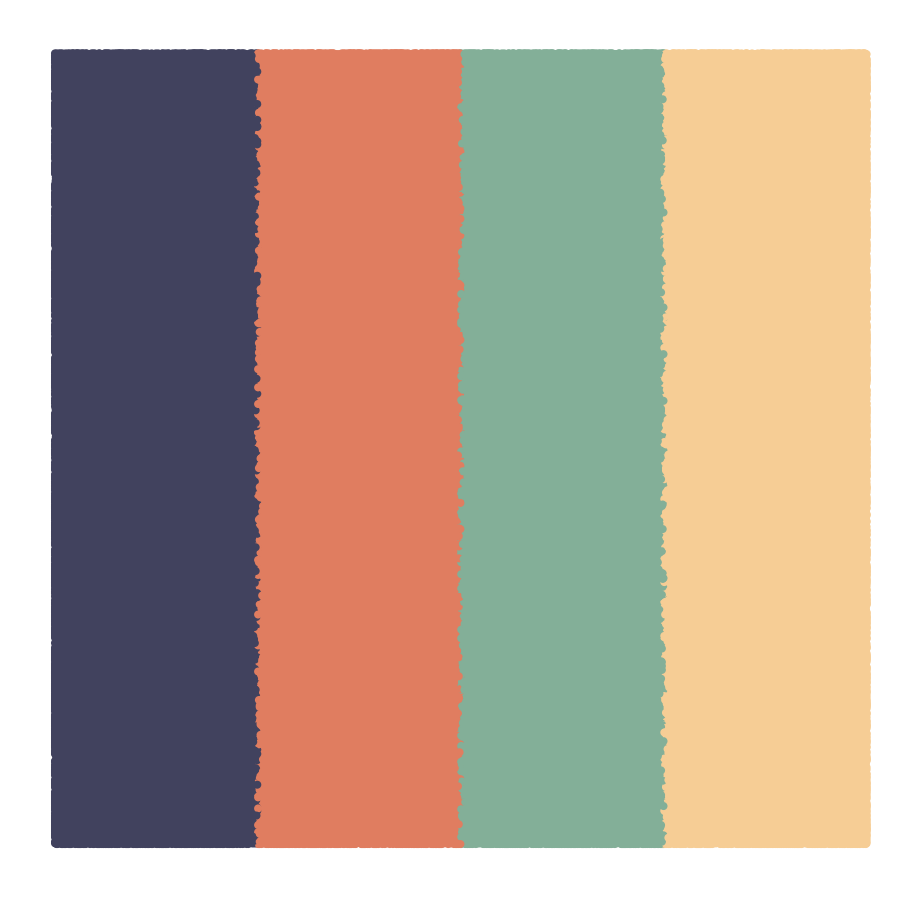

In [102]:
#will take a long time
plt.figure(figsize=(8,8))
plt.scatter(sim_sc_loc[:,0],sim_sc_loc[:,1],c=sim_sc_loc[:,2],marker=".",cmap=cm)
plt.gca().spines[['left','right','top','bottom']].set_color('none') 
plt.axis('off')
plt.savefig("../Figures/fig3_scatterplot_spatialPCA_clus4_500000.png",dpi=100)
plt.show()
plt.close()

In [141]:
#sample 5000 as cell
sim_sc_loc = SpatialPCA_cell_level_sim(Num_sample=1000,
                            Num_celltype=4,
                            image_width=1000,
                            image_height=1000,
                            scenarios_mode="scenario_1")

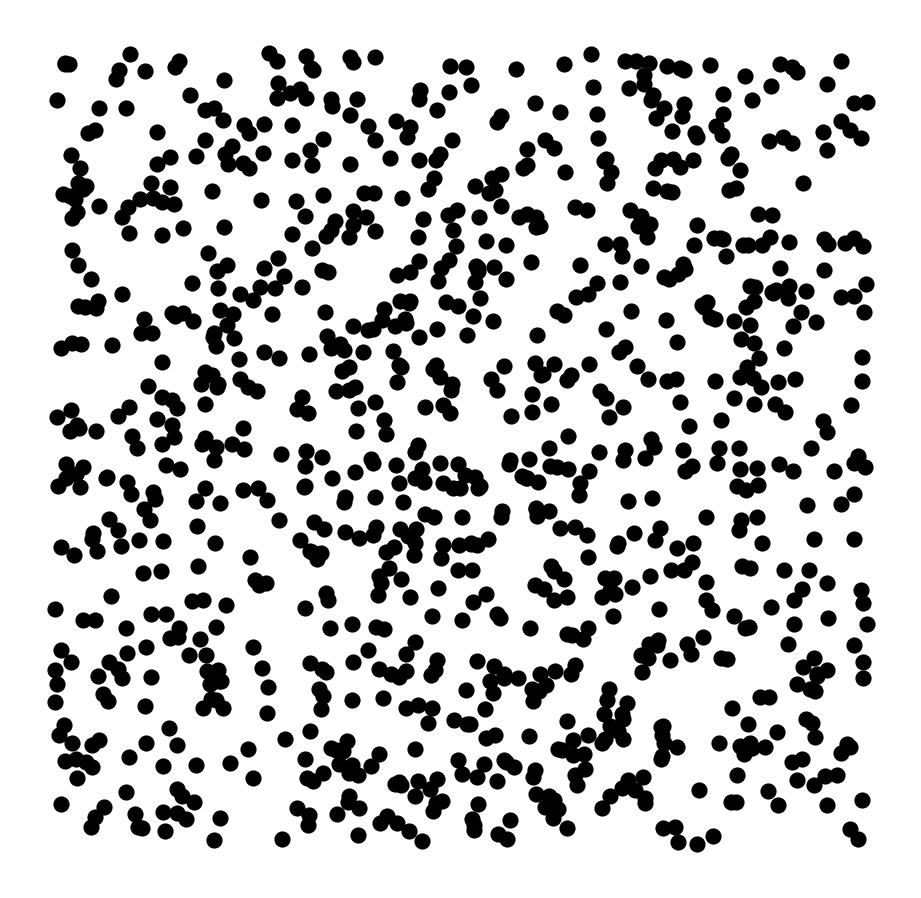

In [146]:
plt.figure(figsize=(8,8))
plt.scatter(sim_sc_loc[:,0],sim_sc_loc[:,1],marker=".",s=200,cmap='viridis',c = 'black') #c=sim_sc_loc[:,2]
plt.gca().spines[['left','right','top','bottom']].set_color('none') 
plt.axis('off')
plt.savefig("../Figures/fig3_scatterplot_spatialPCA_clus4_5000.png",dpi=100)
plt.show()
plt.close()

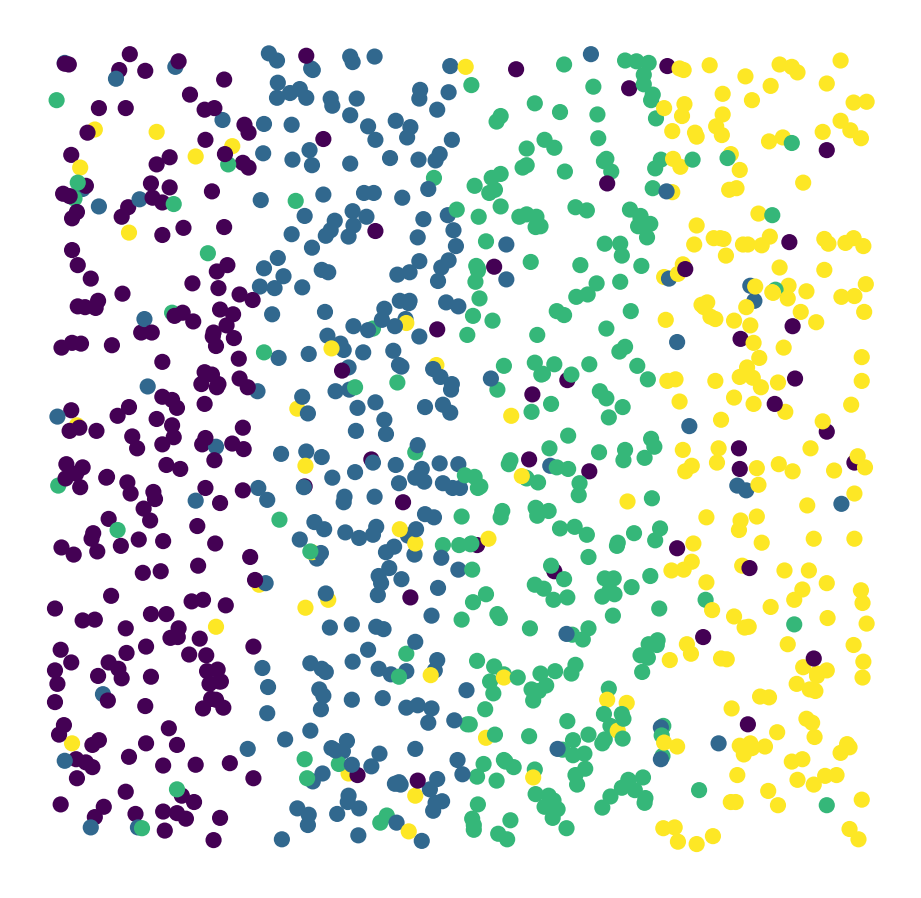

In [149]:
plt.figure(figsize=(8,8))
plt.scatter(sim_sc_loc[:,0],sim_sc_loc[:,1],marker=".",s=200,c=sim_sc_loc[:,3]) 
plt.gca().spines[['left','right','top','bottom']].set_color('none') 
plt.axis('off')

#plt.legend(['celltype1','celltype2','celltype3','celltype4'],loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
plt.savefig("../Figures/fig3_scatterplot_spatialPCA_ct4.png",dpi=100)
plt.show()
plt.close()

# other methods

In [52]:

# full_sample=100
# Num_celltype=4
# a, b = np.meshgrid(range(10),
#                     range(10),
#                     indexing='ij')
# print(a.shape,b.shape)
# print('a:',a.reshape(-1),'\n','b:',b.reshape(-1))
# layer_label = np.repeat(np.arange(Num_celltype),full_sample/Num_celltype)
# print('layer:',layer_label)
# #layer_label #修改下面函数里这个layer_label就能做出不同图形
# c = round(10/4)
# a = a.reshape(-1)
# b = b.reshape(-1)
# row = np.where((a>c) & (a<=(10-c)))[0]
# col = np.where((b>c) & (b<=(10-c)))[0]
# row.shape

In [9]:
#回字？试试10*10
def muti_circle(row=10, col=10, Num_celltype = 4):
    layer_label = np.zeros(row*col,dtype = np.int32)
    #n_spots = row*col
    layer_width_a = round(row/(2*Num_celltype))
    layer_width_b = round(col/(2*Num_celltype))
    a, b = np.meshgrid(range(row),
                    range(col),
                    indexing='ij')
    a = a.reshape(-1)
    b = b.reshape(-1)
    for i in range(1,Num_celltype):
        layer_index = np.intersect1d(np.where((a>=(layer_width_a*i)) & (a<(row-(layer_width_a*i))))[0],np.where((b>=(layer_width_b*i)) & (b<(col-(layer_width_b*i))))[0])
        layer_label[layer_index] = i
        
    return a, b, layer_label
#np.intersect1d(row,col)

#np.where()

In [10]:
#四个角
def muti_square(row=10, col=10, Num_celltype = 4):
    layer_label = np.zeros(row*col,dtype = np.int32)
    #n_spots = row*col
    bound_a = round(row/2)
    bound_b = round(col/2)
    a, b = np.meshgrid(range(row),
                    range(col),
                    indexing='ij')
    a = a.reshape(-1)
    b = b.reshape(-1)
    layer_index1 = np.intersect1d(np.where((a>=bound_a))[0],np.where((b< bound_b))[0])
    layer_index2 = np.intersect1d(np.where((a< bound_a))[0],np.where((b>=bound_b))[0])
    layer_index3 = np.intersect1d(np.where((a>=bound_a))[0],np.where((b>=bound_b))[0])
    layer_label[layer_index1] = 1
    layer_label[layer_index2] = 2
    layer_label[layer_index3] = 3
        
    return a, b, layer_label

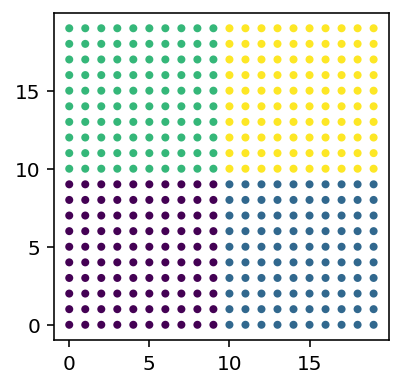

In [13]:
a, b, layer_label = muti_square(row=20, col=20, Num_celltype = 4)
plt.figure(figsize=(3,3))
plt.scatter(a,b,c=layer_label,marker=".")

## 创建一个SpatialPCA_cell_level_sim 的plus版本

In [11]:
def naive_cell_level_sim(Num_sample = None, Num_celltype = 4,
                image_width = None, image_height = None,
                scenarios_mode = "scenario_1",method = "SpatialPCA"):
    '''
    method ={ 'SpatialPCA','muti_circle','muti_square'}
    '''
    full_sample = image_width * image_height
    a, b = np.meshgrid(np.arange(image_width),
                        np.arange(image_height),
                        indexing='ij')     
    if method == 'SpatialPCA':

        ## Num_celltype is equal to Num_layer
        layer_label = np.repeat(np.arange(Num_celltype),full_sample/Num_celltype)
        
    if method == 'muti_circle':
        _, _, layer_label = muti_circle(row=image_width, col=image_height, Num_celltype = 4)
    if method == 'muti_square':
        _, _, layer_label = muti_square(row=image_width, col=image_height, Num_celltype = 4)
    
    
    ct_label_init = np.zeros((full_sample))
    sc_loc = np.vstack((a.reshape(-1), b.reshape(-1),layer_label,ct_label_init)).T
    rand_index = np.random.choice(np.arange(full_sample),Num_sample,replace = False)
   
    sim_sc_loc = sc_loc[rand_index]
    
    ## 对不同的层，按照不同的情景，抽不同类型的细胞
    for i in range(Num_celltype):
        sc_layer_idx = np.where(sim_sc_loc[:, 2] == i)[0]
        sim_sc_loc[sc_layer_idx, 3] = np.argmax(
                                np.random.multinomial(n=1,
                                  pvals=move_list(scenarios[scenarios_mode], k=-i),
                                  size=len(sc_layer_idx)), 1)   #多项分布
        
    return sim_sc_loc    


In [98]:
#muti_circle
sim_sc_loc_circle = naive_cell_level_sim(Num_sample=500000,
                            Num_celltype=4,
                            image_width=1000,
                            image_height=1000,
                            scenarios_mode="scenario_1",
                            method = "muti_circle")

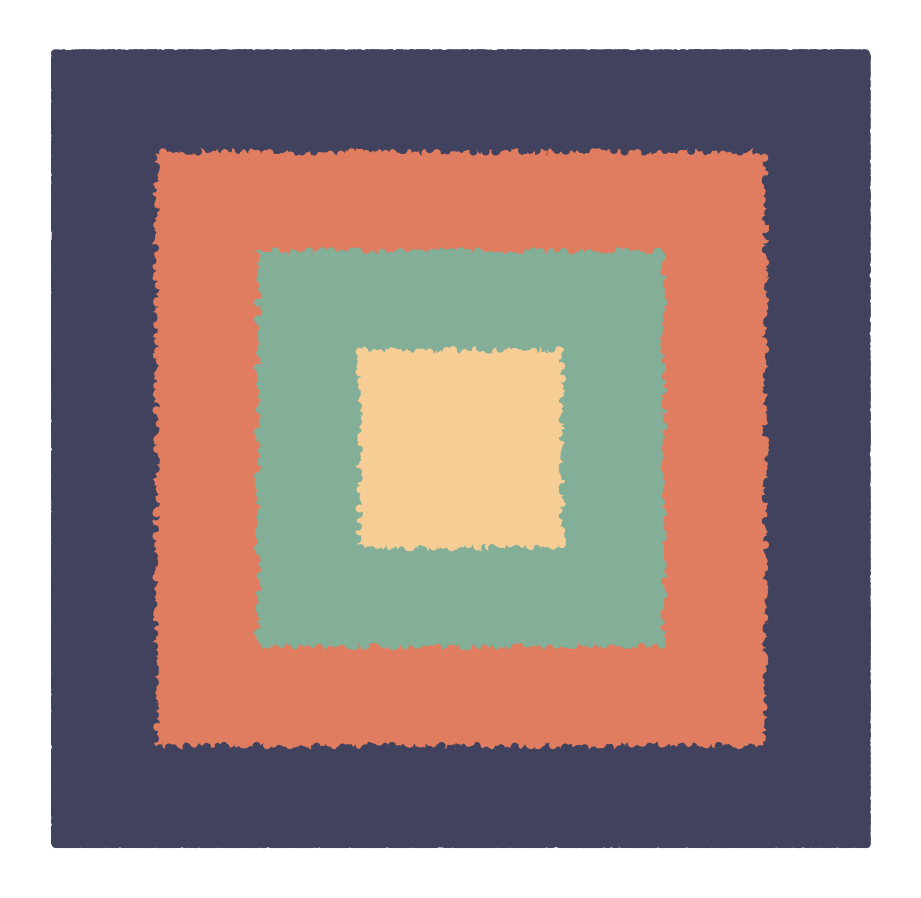

In [104]:
#will take a long time
plt.figure(figsize=(8,8))
plt.scatter(sim_sc_loc_circle[:,0],sim_sc_loc_circle[:,1],c=sim_sc_loc_circle[:,2],marker=".",cmap=cm)
plt.gca().spines[['left','right','top','bottom']].set_color('none') 
plt.axis('off')
plt.savefig("../Figures/fig3_scatterplot_muti_circle_500000.png",dpi=100)
plt.show()
plt.close()

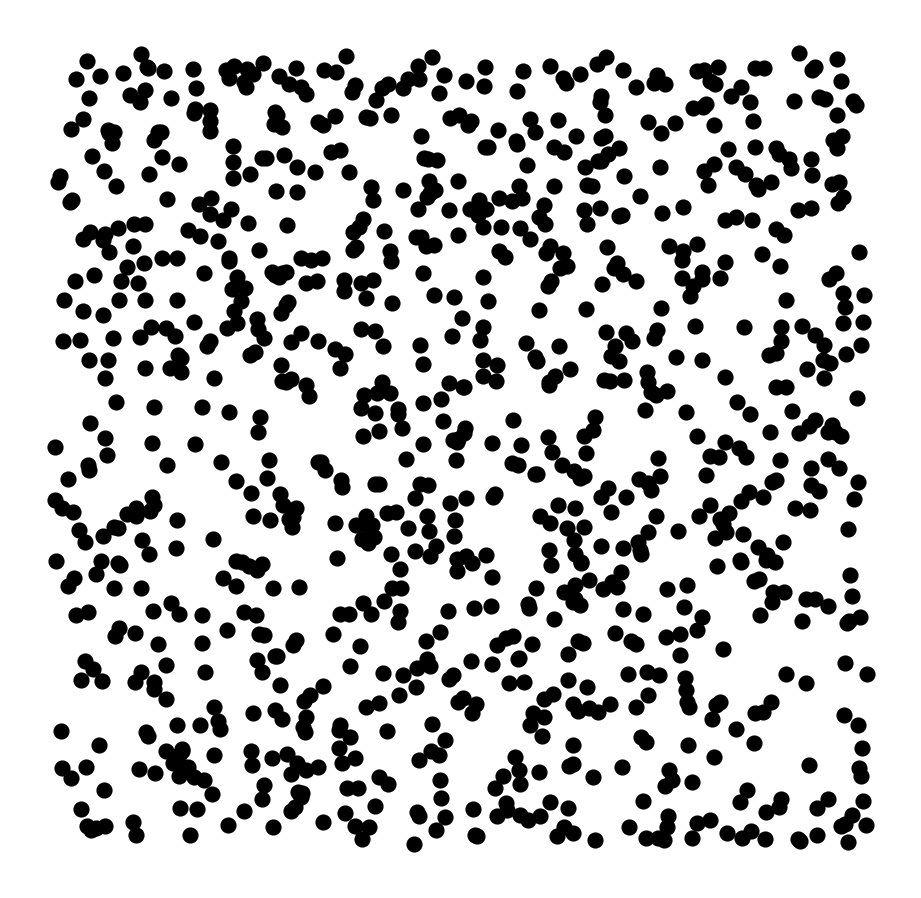

In [150]:
sim_sc_loc_circle = naive_cell_level_sim(Num_sample=1000,
                            Num_celltype=4,
                            image_width=1000,
                            image_height=1000,
                            scenarios_mode="scenario_1",
                            method = "muti_circle")
plt.figure(figsize=(8,8))
plt.scatter(sim_sc_loc_circle[:,0],sim_sc_loc_circle[:,1],c='black',marker=".",s=200)
plt.gca().spines[['left','right','top','bottom']].set_color('none') 
plt.axis('off')
plt.savefig("../Figures/fig3_scatterplot_muti_circle_5000.png",dpi=100)
plt.show()
plt.close()

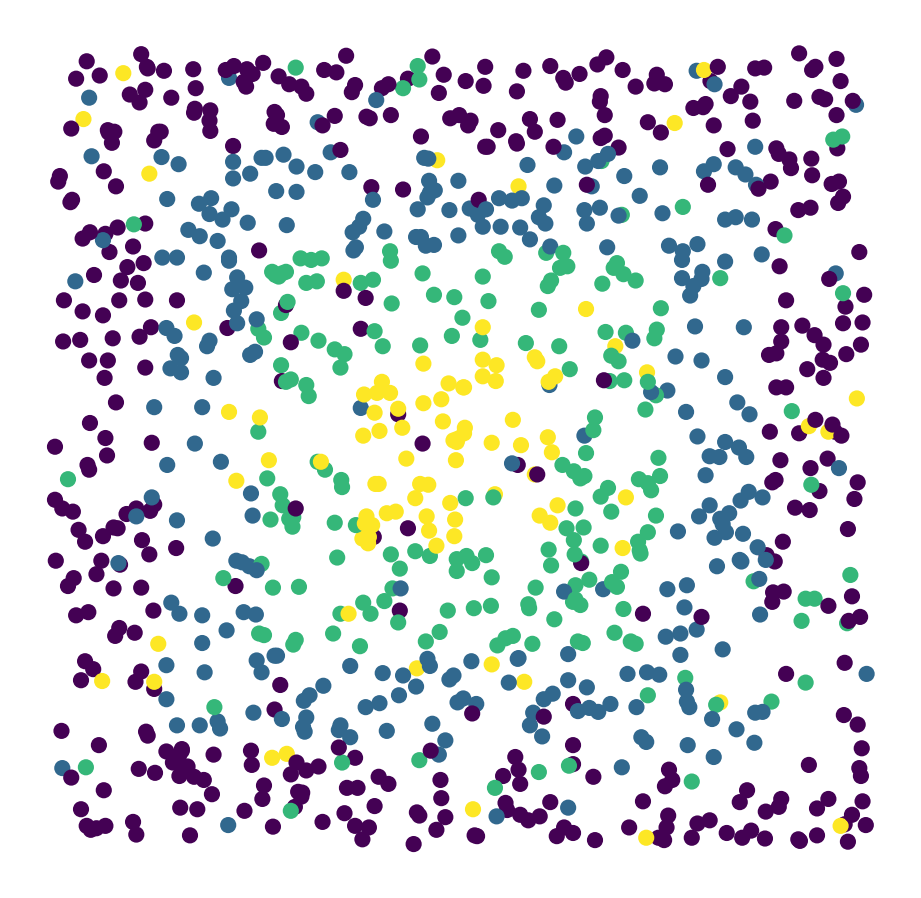

In [151]:
plt.figure(figsize=(8,8))
plt.scatter(sim_sc_loc_circle[:,0],sim_sc_loc_circle[:,1],c=sim_sc_loc_circle[:,3],marker=".",s=200)
plt.gca().spines[['left','right','top','bottom']].set_color('none') 
plt.axis('off')
plt.savefig("../Figures/fig3_scatterplot_muti_circle_ct4.png",dpi=100)
plt.show()
plt.close()

In [107]:
#muti_square
sim_sc_loc_square = naive_cell_level_sim(Num_sample=500000,
                            Num_celltype=4,
                            image_width=1000,
                            image_height=1000,
                            scenarios_mode="scenario_1",
                            method = "muti_square")

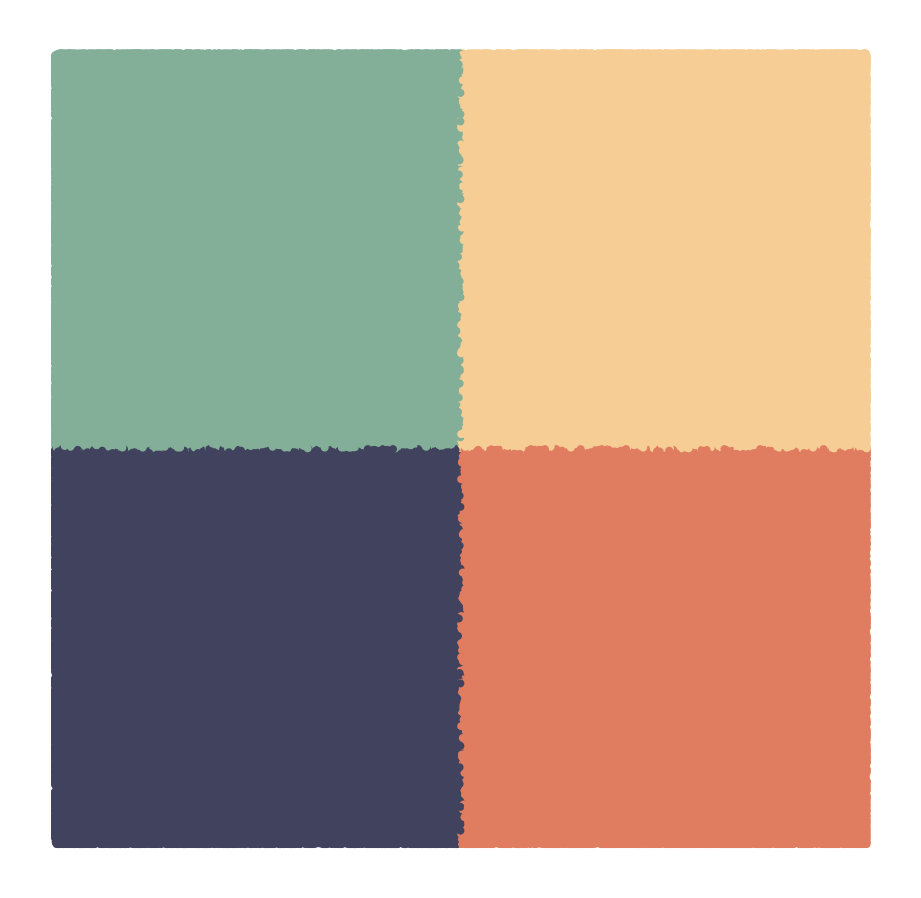

In [108]:
#will take a long time
plt.figure(figsize=(8,8))
plt.scatter(sim_sc_loc_square[:,0],sim_sc_loc_square[:,1],c=sim_sc_loc_square[:,2],marker=".",cmap=cm)
plt.gca().spines[['left','right','top','bottom']].set_color('none') 
plt.axis('off')
plt.savefig("../Figures/fig3_scatterplot_muti_square_500000.png",dpi=100)
plt.show()
plt.close()

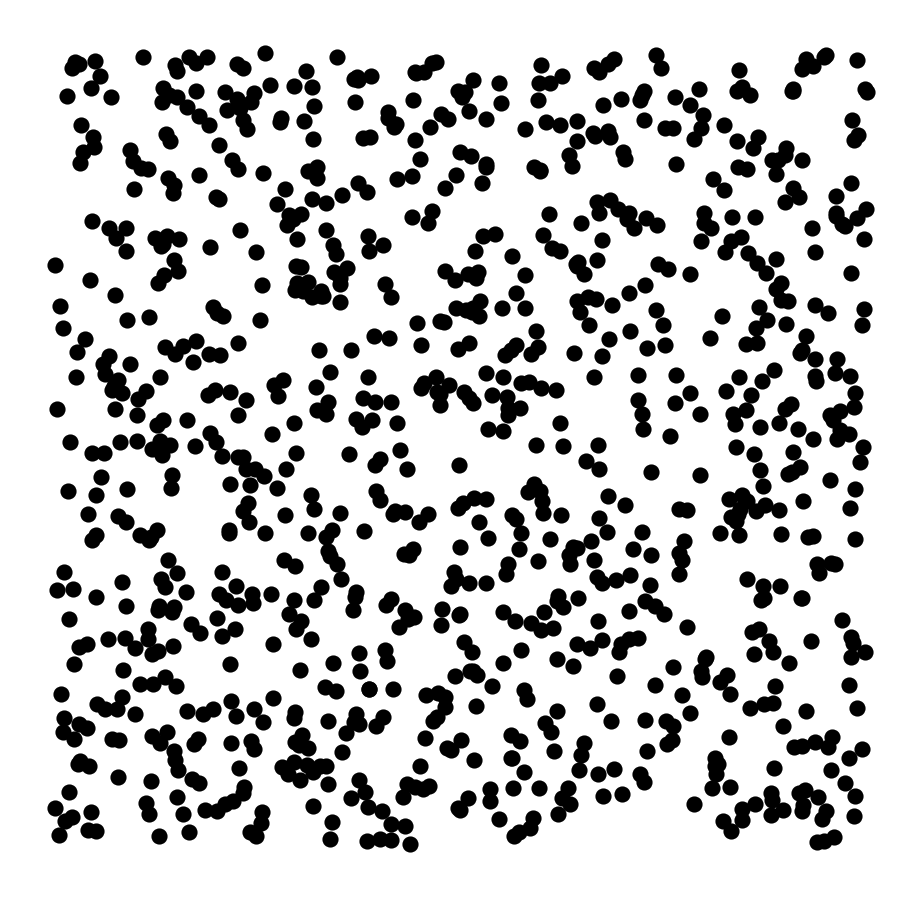

In [152]:
sim_sc_loc_square = naive_cell_level_sim(Num_sample=1000,
                            Num_celltype=4,
                            image_width=1000,
                            image_height=1000,
                            scenarios_mode="scenario_1",
                            method = "muti_square")
plt.figure(figsize=(8,8))
plt.scatter(sim_sc_loc_square[:,0],sim_sc_loc_square[:,1],c='black',marker=".",s=200)
plt.gca().spines[['left','right','top','bottom']].set_color('none') 
plt.axis('off')
plt.savefig("../Figures/fig3_scatterplot_muti_square_5000.png",dpi=100)
plt.show()
plt.close()

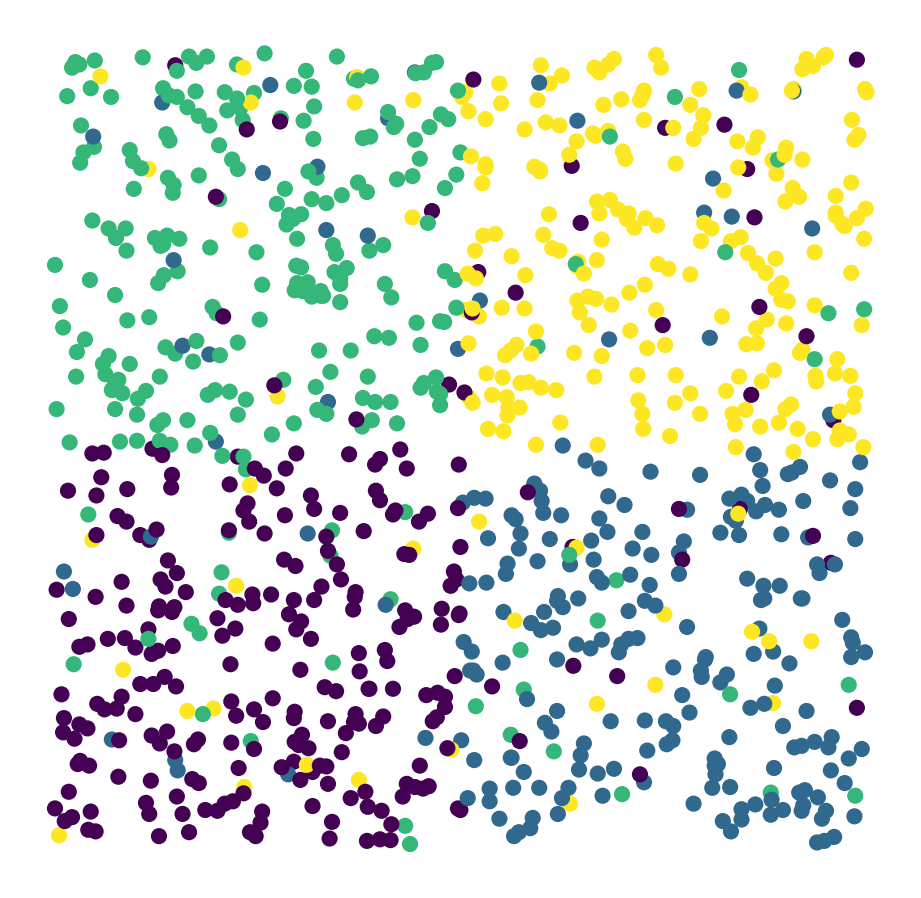

In [153]:
plt.figure(figsize=(8,8))
plt.scatter(sim_sc_loc_square[:,0],sim_sc_loc_square[:,1],c=sim_sc_loc_square[:,3],marker=".",s=200)
plt.gca().spines[['left','right','top','bottom']].set_color('none') 
plt.axis('off')
plt.savefig("../Figures/fig3_scatterplot_muti_square_ct4.png",dpi=100)
plt.show()
plt.close()

#### spot level

In [12]:
#use SpatialPCA to merge a spot level data
def SpatialPCA_spot_level_sim(spot_diameter = None, image_width = None,image_height=  None,
                             sim_sc_loc = None, merge = False,gap = 0):
    grid_row = int(image_width / spot_diameter)
    grid_col = int(image_height / spot_diameter)
    grid_num = grid_row * grid_col
    points_x_indices = (sim_sc_loc[:, 0] / spot_diameter).astype(int)
    points_y_indices = (sim_sc_loc[:, 1] / spot_diameter).astype(int)
    
    ## 细胞的spot编号
    cell_spot_id = (points_x_indices*grid_col + points_y_indices).astype(int)
    ## 细胞的编号
    cell_id = np.arange(cell_spot_id.size)
    
    
    ##  替换np.where 每一个grid  obtain 每一个spot的cell的index 行spot 列cell_id
    spot_cell_idx_matrix = csr_matrix(
        (np.ones(cell_spot_id.size), (cell_spot_id, cell_id)),
        shape=(grid_num, cell_spot_id.size))
    
    ## 对细胞的层注释做onehot
    cell_layer_onehot = get_onehot_ct(sim_sc_loc[:,2])
    
    ## should pay attention to these spots which not contain cells
    ## 得到一个spot里面细胞类型计数
    spot_layer = spot_cell_idx_matrix * cell_layer_onehot
    
    ## 提取没有mask细胞的spot
    mask = np.all(spot_layer == 0, axis=1)
    
    ## 备注存在全为0的行 spot
    spot_layer = np.argmax(spot_layer,axis=1)
    
    ## 取网格的中心点作为spot坐标
    a, b = np.meshgrid(np.arange(grid_row),
                   np.arange(grid_col),
                   indexing='ij')
    spot_pixel_row = (a.reshape(-1)+0.5)*spot_diameter
    spot_pixel_col = (b.reshape(-1)+0.5)*spot_diameter
    
    spot_loc =  np.vstack((spot_pixel_row, spot_pixel_col,spot_layer)).T
    subspot_loc = spot_loc[~mask] ## 去除spot里面没有cell的spot  作者认为这种网格是subspot，
                                  ## 如果需要像10X ST一样，需要9个网格merge

    if merge is True:
        
        windows_row = 3
        windows_col = 3
        gap = gap

        ## 边缘没有3*3的网格,设不设置gap?
        spot_row_num = int(grid_row/(windows_row+gap))
        spot_col_num = int(grid_col/(windows_col+gap))

        ## lra 与lrb是9个网格的中心网格 实际是中心网格左下角的点的坐标
        lra = a[np.arange(1, spot_row_num*(windows_row+gap), (windows_row+gap)
                  ), :len(np.arange(1, spot_col_num*(windows_col+gap), (windows_col+gap)))].reshape(-1)
        lrb = b[:len(np.arange(1, spot_row_num*(windows_row+gap), (windows_row+gap))),
            np.arange(1, spot_col_num*(windows_col+gap), (windows_col+gap))].reshape(-1)   
        
        ## 中心网格标号
        lrspot_layer_idx = lra*grid_col+lrb   
        
        ## get中心点的邻居，即9个网格 包括自己，
        sn = get_spaital_network(Num_sample=spot_loc.shape[0],spatial=spot_loc[:,:2],
                         n_neighs=8,coord_type = "grid",n_rings = 1,set_diag=True)
        
        spot_layer_onehot = get_onehot_ct(spot_loc[:,2])
        
        ## 得到merged spot 的9个spot layer标签统计中最多的标签
        merged_spot_layer = np.argmax(sn[lrspot_layer_idx] * spot_layer_onehot,axis=1)
        merged_spot_pixel_row = (lra.reshape(-1)+0.5)*spot_diameter
        merged_spot_pixel_col = (lrb.reshape(-1)+0.5)*spot_diameter
        merged_spot_loc =  np.vstack((merged_spot_pixel_row, 
                                      merged_spot_pixel_col,
                                      merged_spot_layer)).T
        return subspot_loc,merged_spot_loc
    else:
        return subspot_loc

In [44]:
#cm=mpl.colors.ListedColormap(["#E41A1C","#377EB8","#4DAF4A","#984EA3"])

<IPython.core.display.Javascript object>

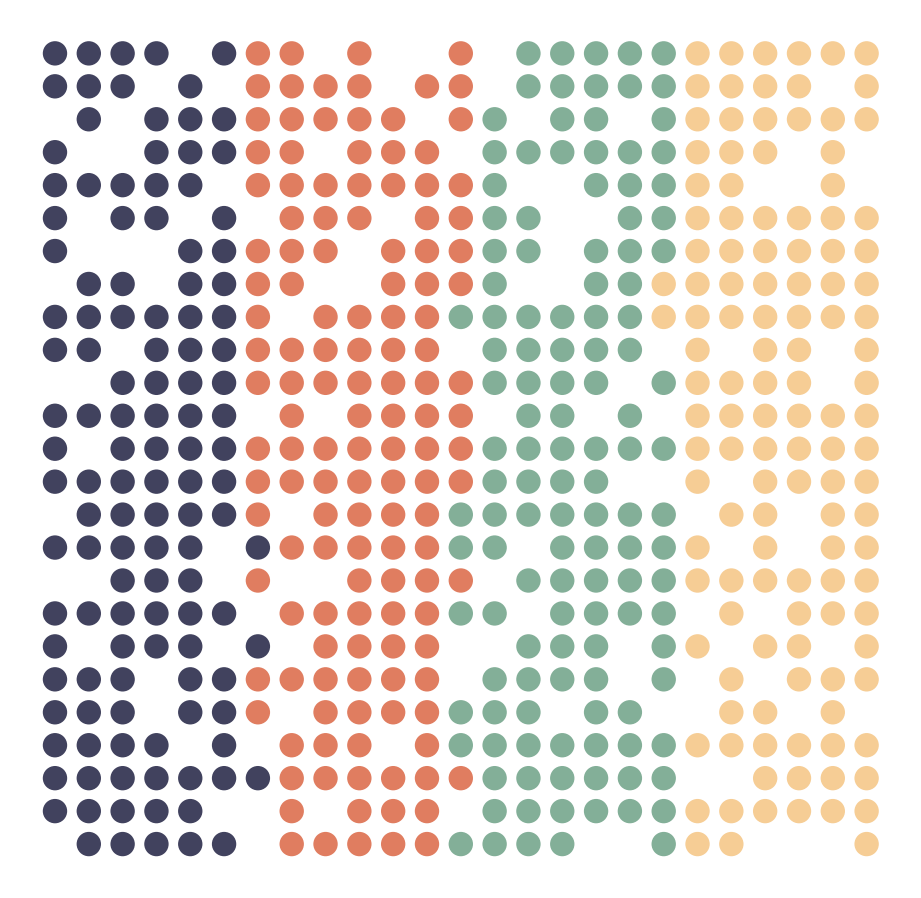

In [154]:
subspot_loc = SpatialPCA_spot_level_sim(spot_diameter = 40, image_width = 1000,image_height=  1000,
                             sim_sc_loc = sim_sc_loc,merge = False,gap=0)

plt.figure(figsize=(8,8))
plt.scatter(subspot_loc[:,0],subspot_loc[:,1],c=subspot_loc[:,2],marker=".",s = 500,cmap=cm) #,cmap="jet"

plt.gca().spines[['left','right','top','bottom']].set_color('none') 
plt.axis('off')
plt.savefig("../Figures/fig3_scatterplot_spatialPCA_spot.png",dpi=100)
plt.show()
plt.close()

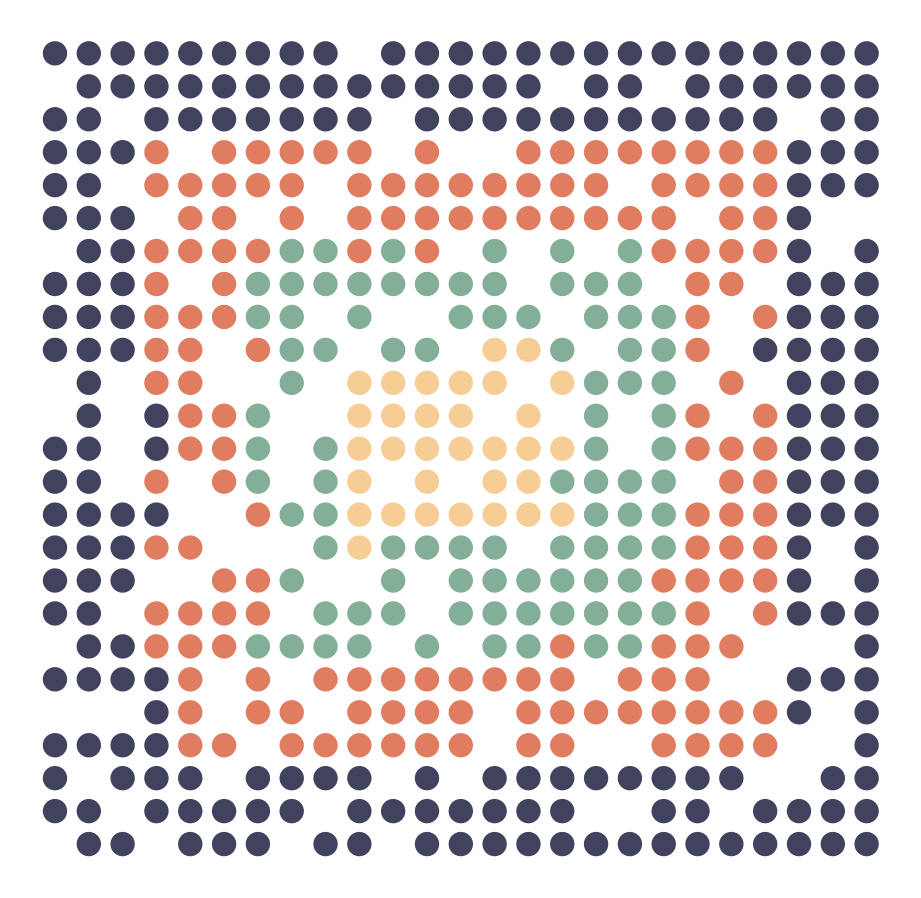

In [155]:
subspot_loc1 = SpatialPCA_spot_level_sim(spot_diameter = 40, image_width = 1000,image_height=  1000,
                             sim_sc_loc = sim_sc_loc_circle,merge = False,gap=0)

plt.figure(figsize=(8,8))
plt.scatter(subspot_loc1[:,0],subspot_loc1[:,1],c=subspot_loc1[:,2],marker=".",s = 500,cmap=cm) #,cmap="jet"

plt.gca().spines[['left','right','top','bottom']].set_color('none') 
plt.axis('off')
plt.savefig("../Figures/fig3_scatterplot_circle_spot.png",dpi=100)
plt.show()
plt.close()

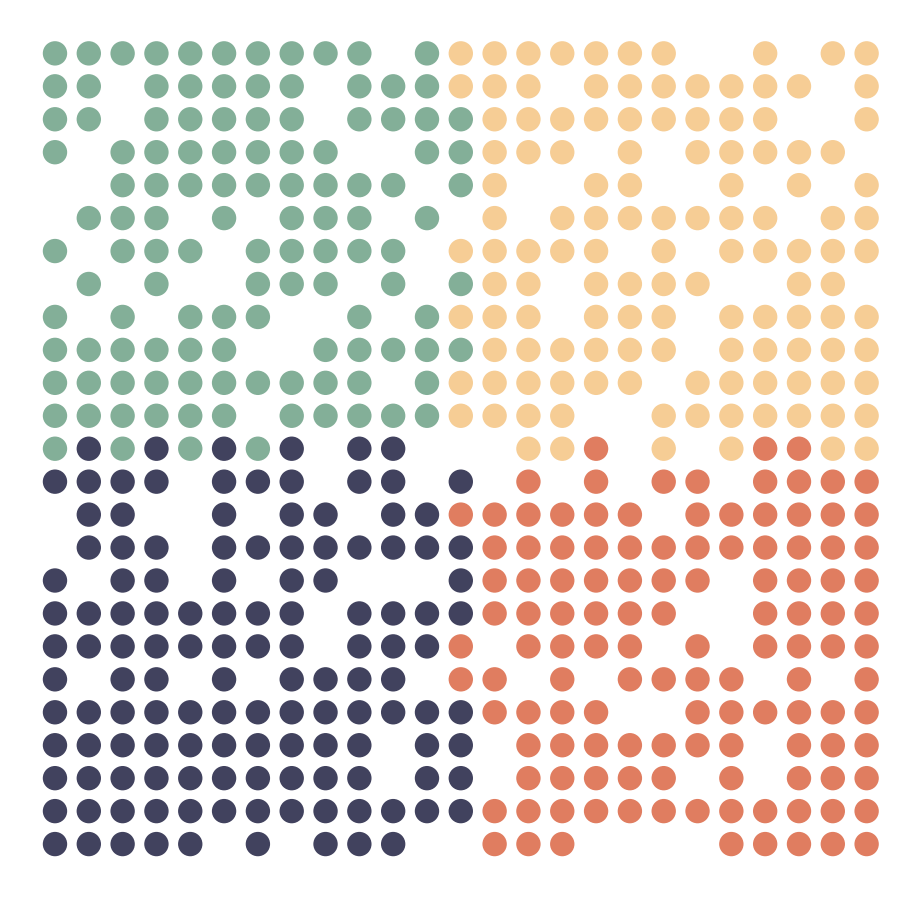

In [156]:
subspot_loc2 = SpatialPCA_spot_level_sim(spot_diameter = 40, image_width = 1000,image_height=  1000,
                             sim_sc_loc = sim_sc_loc_square,merge = False,gap=0)

plt.figure(figsize=(8,8))
plt.scatter(subspot_loc2[:,0],subspot_loc2[:,1],c=subspot_loc2[:,2],marker=".",s = 500,cmap=cm) #,cmap="jet"

plt.gca().spines[['left','right','top','bottom']].set_color('none') 
plt.axis('off')
plt.savefig("../Figures/fig3_scatterplot_square_spot.png",dpi=100)
plt.show()
plt.close()

In [53]:
# subspot_loc, merged_spot_loc = SpatialPCA_spot_level_sim(spot_diameter = 20, image_width = 1000,image_height=  1000,
#                              sim_sc_loc = sim_sc_loc,merge = True,gap= 0)

In [157]:
# plt.figure(figsize=(5,5))
# plt.scatter(merged_spot_loc[:,0],merged_spot_loc[:,1],c=merged_spot_loc[:,2],marker=".",s=400)

# plt.gca().spines[['left','right','top','bottom']].set_color('none') 
# plt.axis('off')
# #plt.savefig("../Figures/fig3_scatterplot_spatialPCA_spot.png",dpi=100)
# plt.show()
# plt.close()

In [159]:
#merged_spot_loc.shape

# gnmf模拟数据

In [14]:
#cell level 
sim_sc_loc = SpatialPCA_cell_level_sim(Num_sample=2500,
                            Num_celltype=4,
                            image_width=1000,
                            image_height=1000,
                            scenarios_mode="scenario_1") #500000*4  rows:x,y,layer_label,ct_label_init
#spot level
subspot_loc = SpatialPCA_spot_level_sim(spot_diameter = 40, image_width = 1000,image_height=  1000,
                             sim_sc_loc = sim_sc_loc,merge = False,gap=0)



In [22]:
subspot_loc

array([[ 20.,  20.,   0.],
       [ 20.,  60.,   0.],
       [ 20., 100.,   0.],
       ...,
       [980., 900.,   3.],
       [980., 940.,   3.],
       [980., 980.,   3.]])

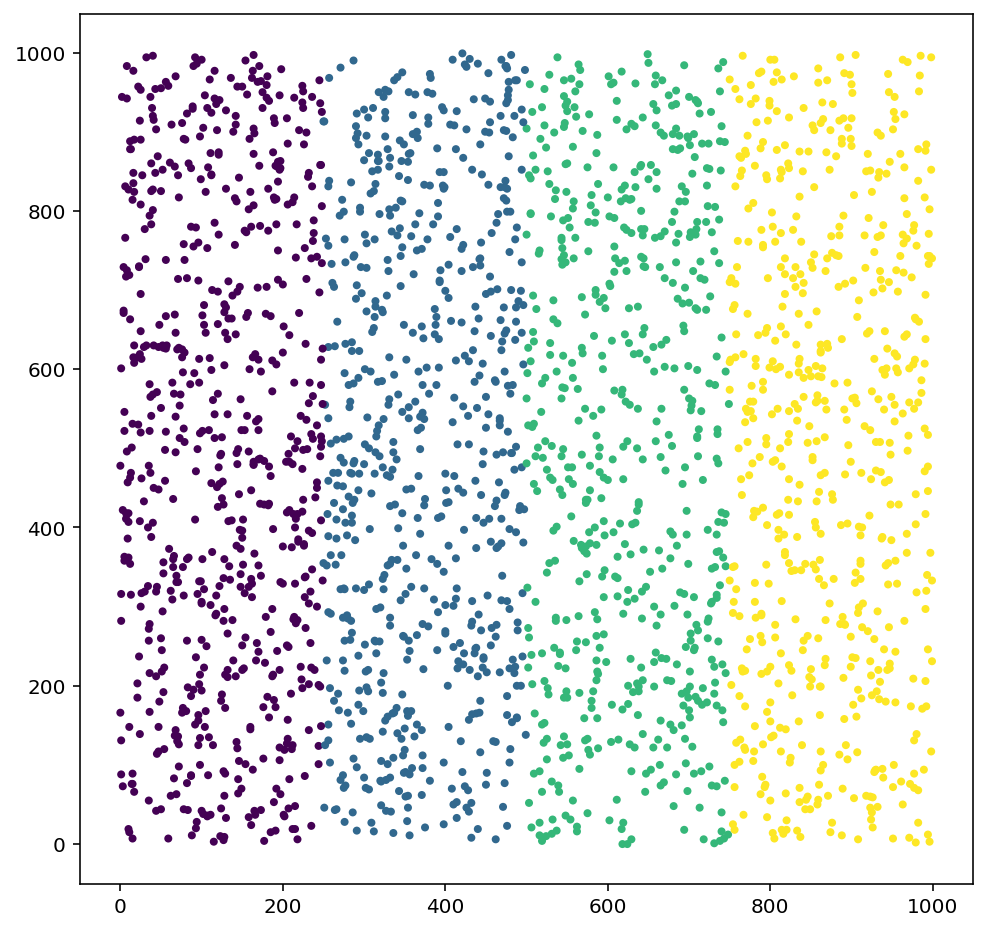

In [21]:
#cell level fig
plt.figure(figsize=(8,8))
plt.scatter(sim_sc_loc[:,0],sim_sc_loc[:,1],c=sim_sc_loc[:,2],marker=".")


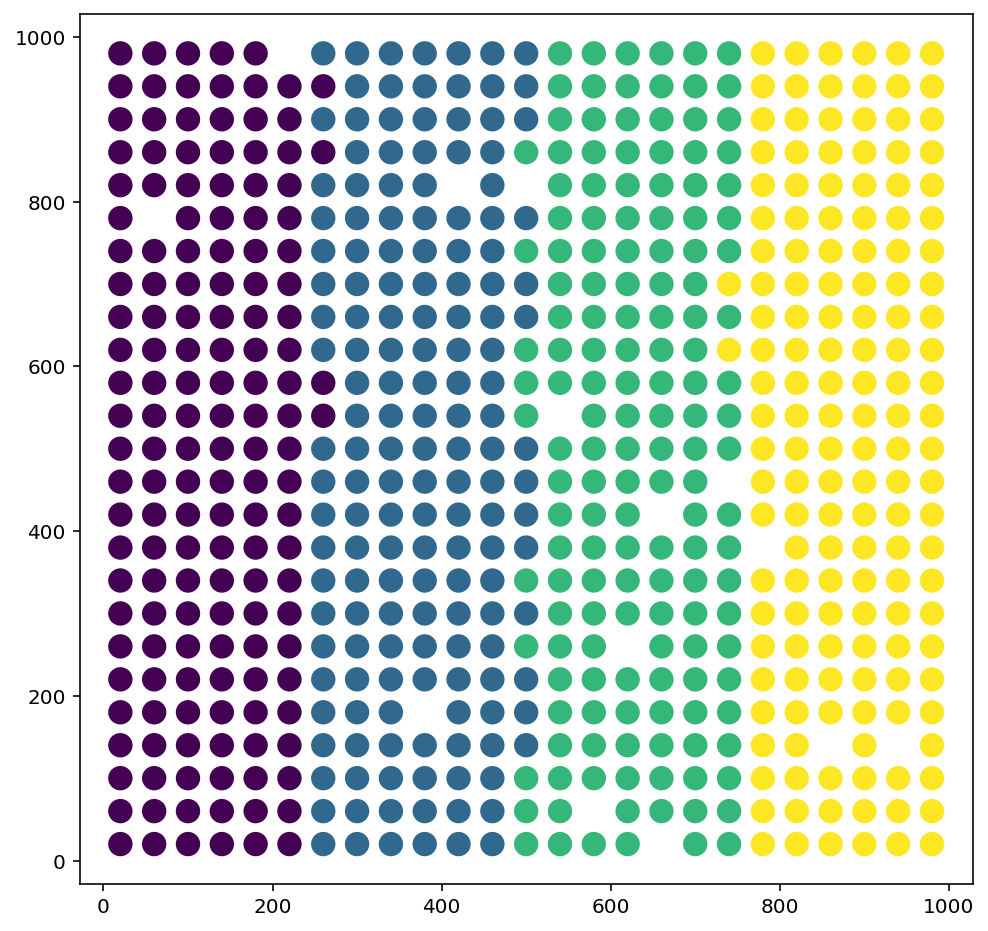

In [19]:
#spot level fig
plt.figure(figsize=(8,8))
plt.scatter(subspot_loc[:,0],subspot_loc[:,1],c=subspot_loc[:,2],marker=".",s = 500) #,cmap="jet"


In [13]:
sim_sc_loc #列代表 x,y,layer_label,ct_label_init

array([[ 40., 828.,   0.,   0.],
       [785., 235.,   3.,   3.],
       [243., 948.,   0.,   0.],
       ...,
       [468., 399.,   1.,   1.],
       [495., 106.,   1.,   1.],
       [998., 789.,   3.,   3.]])

In [ ]:
#will take a long time
plt.figure(figsize=(8,8))
plt.scatter(sim_sc_loc[:,0],sim_sc_loc[:,1],c=sim_sc_loc[:,2],marker=".",cmap=cm)
plt.gca().spines[['left','right','top','bottom']].set_color('none') 
plt.axis('off')
plt.savefig("../Figures/fig3_scatterplot_spatialPCA_clus4_500000.png",dpi=100)
plt.show()
plt.close()